In [2]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [10]:
# Load the data
df = pd.read_csv(r'C:\Users\Salih\Documents\GitHub\prediction-system-marginal-price\data\raw\combined_data.csv')

In [11]:
print("Dataset Shape:", df.shape)
df.info()

Dataset Shape: (8785, 97)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8785 entries, 0 to 8784
Data columns (total 97 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               8785 non-null   object 
 1   Adj Close_x              8785 non-null   float64
 2   Close_x                  8785 non-null   float64
 3   High_x                   8785 non-null   float64
 4   Low_x                    8785 non-null   float64
 5   Open_x                   8785 non-null   float64
 6   Volume_x                 8785 non-null   float64
 7   Adj Close_y              8785 non-null   float64
 8   Close_y                  8785 non-null   float64
 9   High_y                   8785 non-null   float64
 10  Low_y                    8785 non-null   float64
 11  Open_y                   8785 non-null   float64
 12  Volume_y                 8785 non-null   float64
 13  price                    8785 non-null   float64
 14

In [12]:
# Eksik veri oranlarını virgülden sonra 2 basamağa yuvarlayın
missing_data_percentage = df.isna().sum() / len(df) * 100
missing_data_percentage = missing_data_percentage.round(2)

# Sonuçları yüzdelik olarak inceleyin
missing_data_percentage


Unnamed: 0       0.00
Adj Close_x      0.00
Close_x          0.00
High_x           0.00
Low_x            0.00
                ...  
bursa_wspd       0.00
bursa_wpgt      95.83
bursa_pres       0.00
bursa_tsun     100.00
bursa_coco       0.00
Length: 97, dtype: float64

In [13]:
print("\nBasic Statistics:")
df.describe().T


Basic Statistics:


,count,mean,std,min,25%,50%,75%,max
Adj Close_x,8785.0,9977.872402,1304.351005,7659.950195,8646.219727,9949.540039,11049.330078,12256.099609
Close_x,8785.0,9977.872402,1304.351005,7659.950195,8646.219727,9949.540039,11049.330078,12256.099609
High_x,8785.0,10012.793634,1303.803506,7739.450195,8684.620117,9961.629883,11088.200195,12263.040039
Low_x,8785.0,9946.401981,1307.557724,7616.209961,8617.889648,9921.690430,11033.269531,12233.469727
Open_x,8785.0,9983.497277,1307.099826,7659.390137,8664.759766,9951.070312,11066.839844,12257.669922
...,...,...,...,...,...,...,...,...
bursa_wspd,8785.0,7.029402,6.605524,0.000000,1.800000,5.400000,11.200000,53.600000
bursa_wpgt,366.0,10.045082,5.970651,3.700000,7.400000,7.400000,11.100000,51.800000
bursa_pres,8785.0,1014.478509,5.967177,980.800000,1010.600000,1014.200000,1018.200000,1036.300000
bursa_tsun,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
columns_to_drop = ['izmir_snow', 'istanbul_tsun', 'ankara_tsun', 'bursa_tsun', 
                 'antalya_tsun', 'izmir_wpgt', 'izmir_tsun', 'istanbul_snow',
                 'ankara_snow', 'antalya_snow', 'bursa_snow', 'bursa_wpgt',
                 'istanbul_wpgt','Volume_x','Volume_y']

# Kolonları silme
df = df.drop(columns=columns_to_drop)
print("Yeni veri seti boyutu:", df.shape)

Yeni veri seti boyutu: (8785, 82)


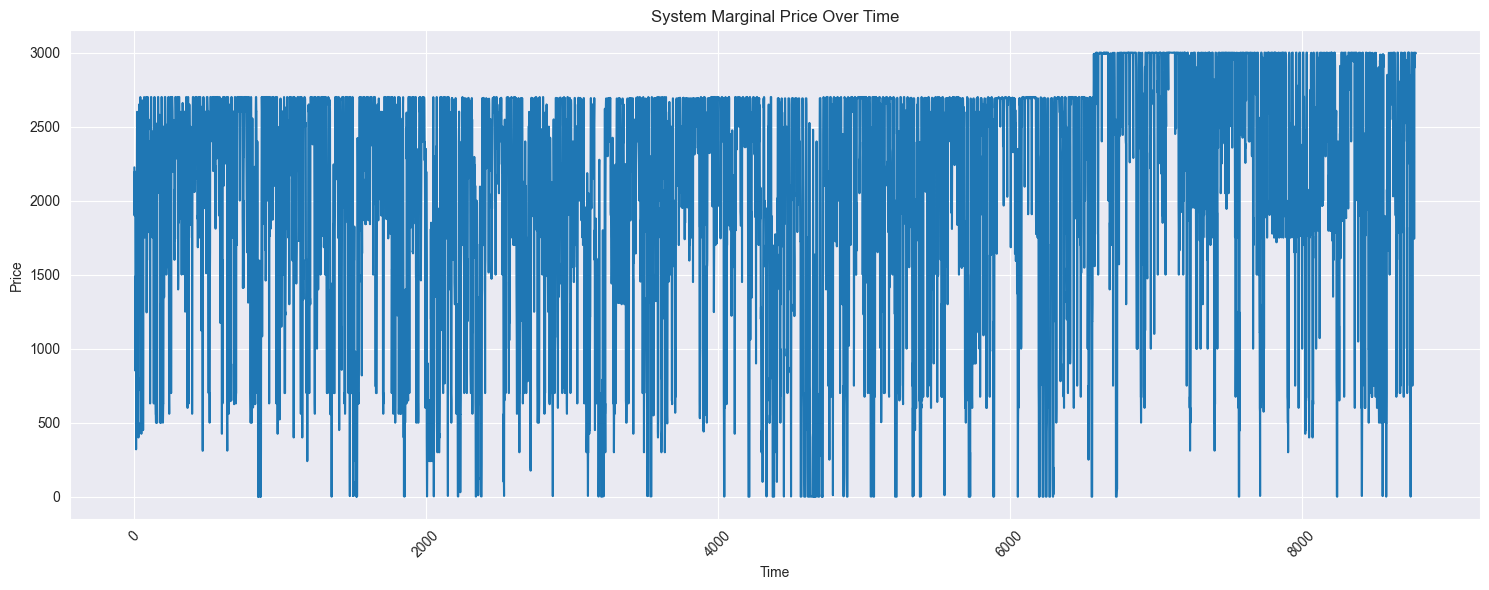

In [15]:
plt.figure(figsize=(15, 6))
plt.plot(df['systemMarginalPrice'])
plt.title('System Marginal Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

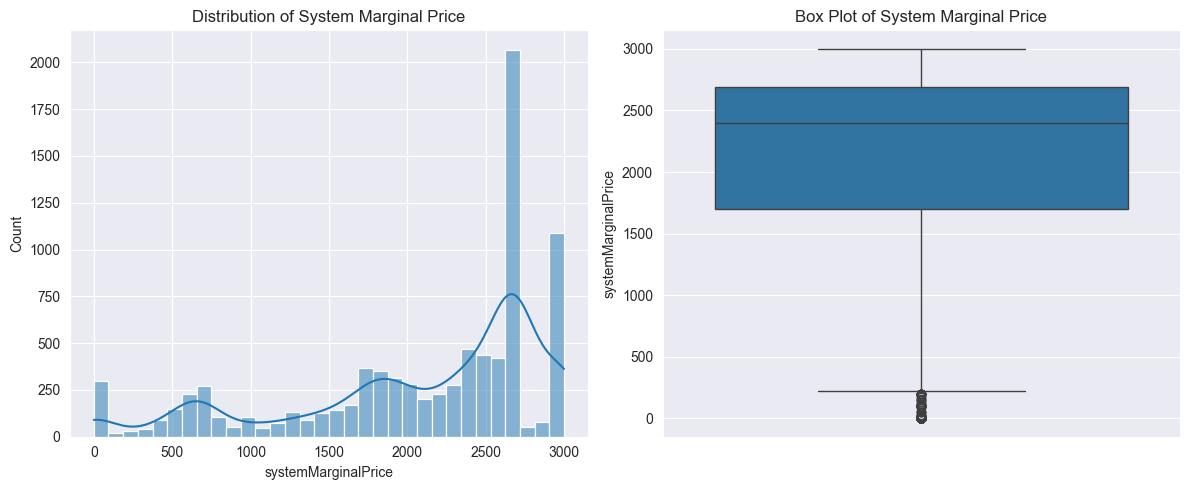

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['systemMarginalPrice'], kde=True)
plt.title('Distribution of System Marginal Price')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['systemMarginalPrice'])
plt.title('Box Plot of System Marginal Price')
plt.tight_layout()
plt.show()

In [17]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
correlations = df[numeric_columns].corr()['systemMarginalPrice'].sort_values(ascending=False)
print("\nCorrelations with System Marginal Price:")
print(correlations)



Correlations with System Marginal Price:
systemMarginalPrice        1.000000
wap                        0.799980
price                      0.734043
downRegulationNet          0.726722
upRegulationNet            0.726722
                             ...   
bursa_ghi                 -0.225777
istanbul_ghi              -0.225777
antalya_pres              -0.228373
downRegulationZeroCoded   -0.640152
smpDirectionId            -0.747502
Name: systemMarginalPrice, Length: 79, dtype: float64


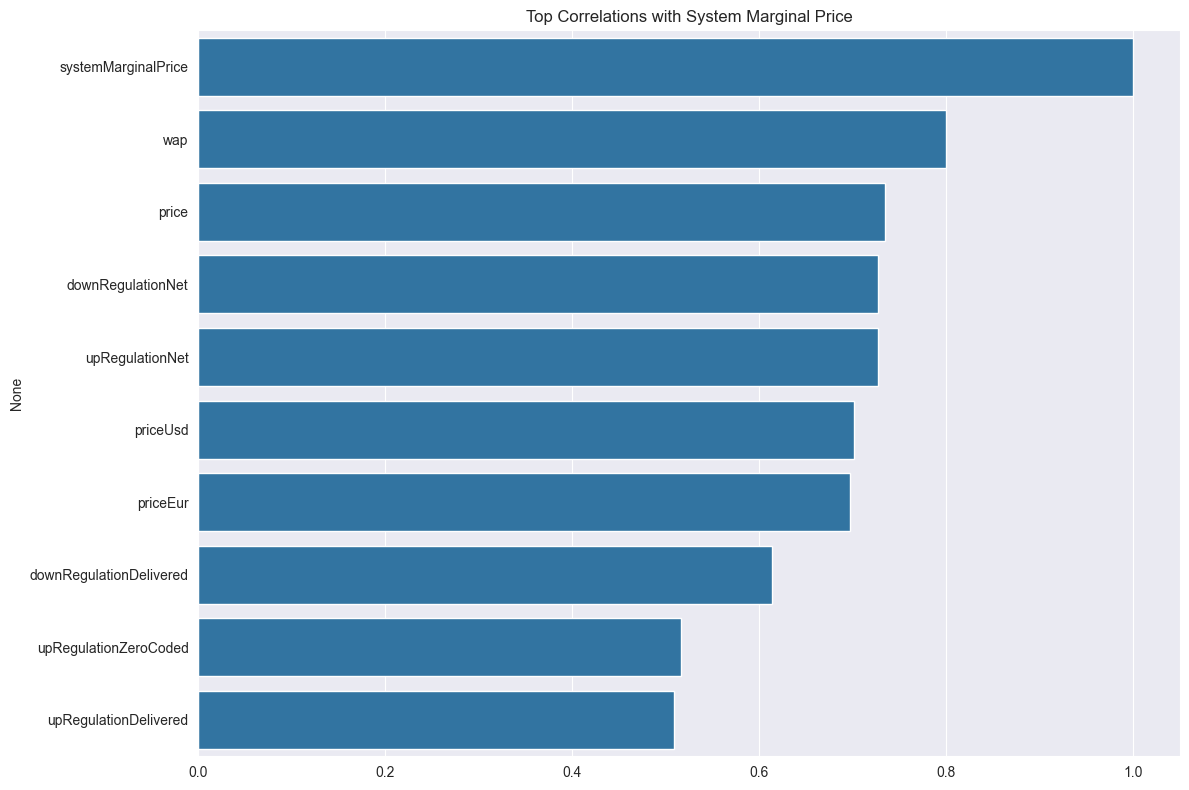

In [18]:
# Visualize top correlations
plt.figure(figsize=(12, 8))
top_corr = correlations[abs(correlations) > 0.1][:10]  # Top 10 correlations above 0.1
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title('Top Correlations with System Marginal Price')
plt.tight_layout()
plt.show()

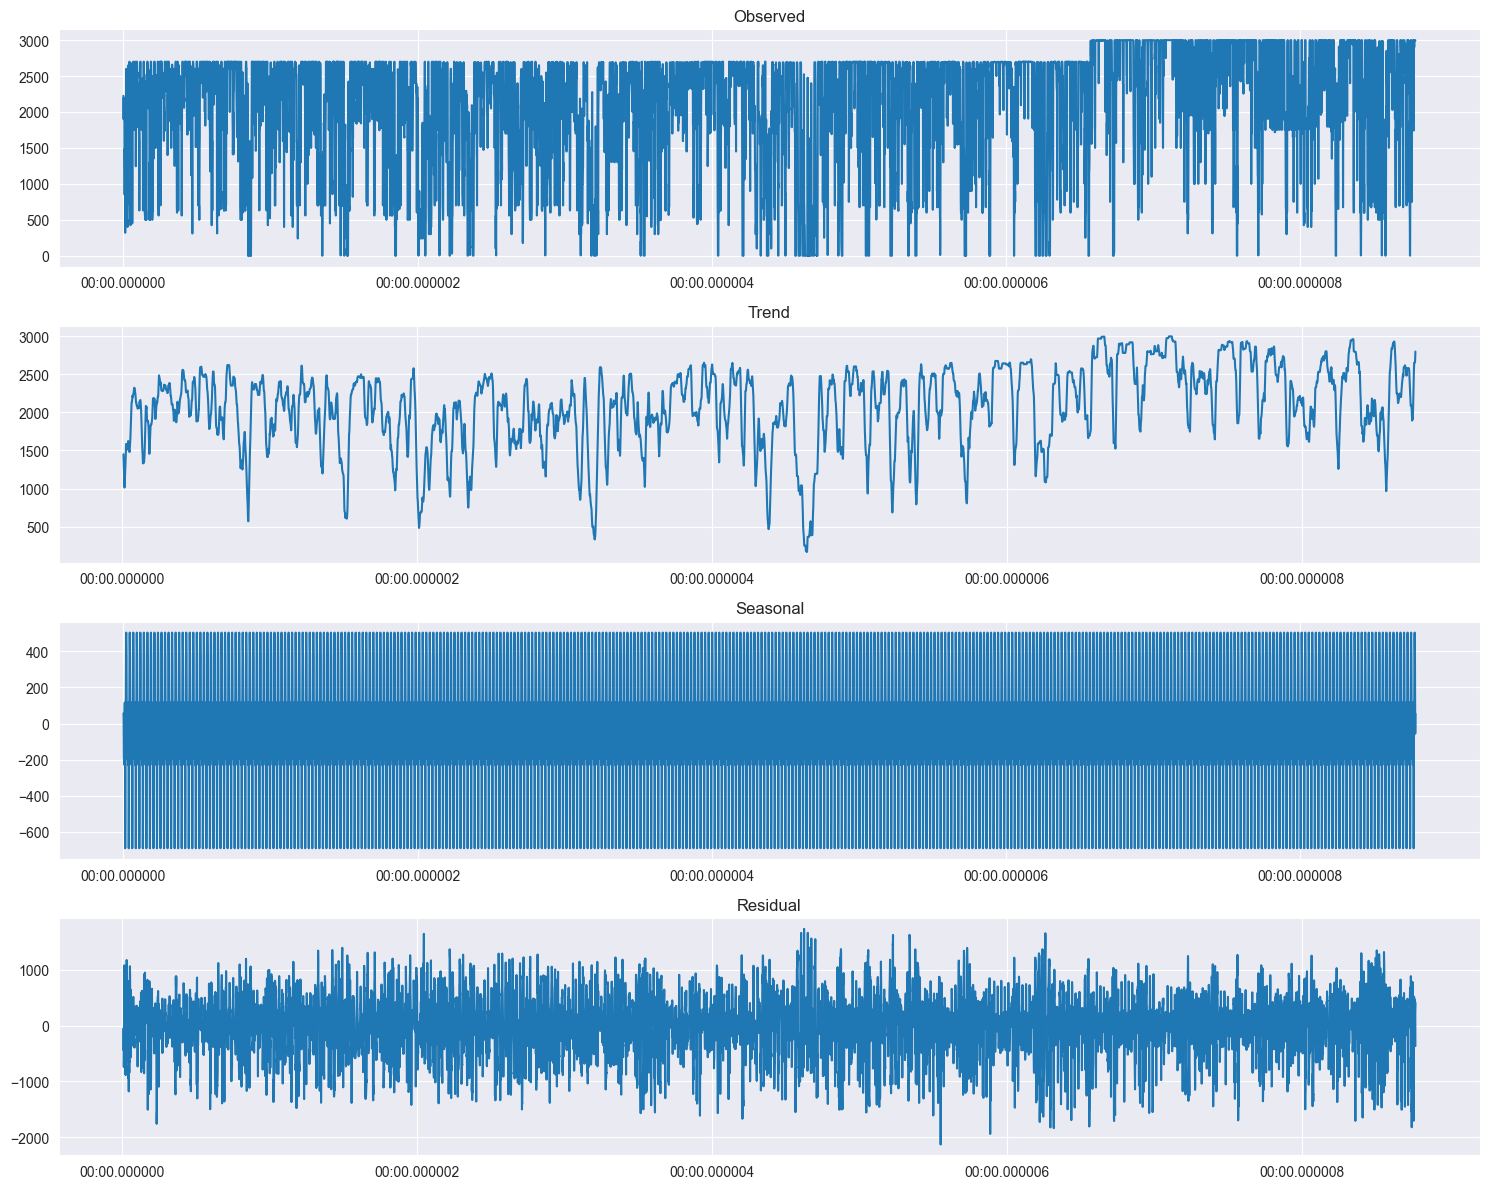

In [19]:
try:
  df.index = pd.to_datetime(df.index)
  decomposition = seasonal_decompose(df['systemMarginalPrice'], period=24)  # Assuming hourly data
  
  plt.figure(figsize=(15, 12))
  plt.subplot(411)
  plt.plot(decomposition.observed)
  plt.title('Observed')
  
  plt.subplot(412)
  plt.plot(decomposition.trend)
  plt.title('Trend')
  
  plt.subplot(413)
  plt.plot(decomposition.seasonal)
  plt.title('Seasonal')
  
  plt.subplot(414)
  plt.plot(decomposition.resid)
  plt.title('Residual')
  
  plt.tight_layout()
  plt.show()
except Exception as e:
  print("Could not perform time series decomposition:", e)


In [20]:
def check_stationarity(series):
  result = adfuller(series.dropna())
  print('ADF Statistic:', result[0])
  print('p-value:', result[1])
  print('Critical values:')
  for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))

print("\nStationarity Test for System Marginal Price:")
check_stationarity(df['systemMarginalPrice'])



Stationarity Test for System Marginal Price:
ADF Statistic: -10.310221455622127
p-value: 3.1998490960947353e-18
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


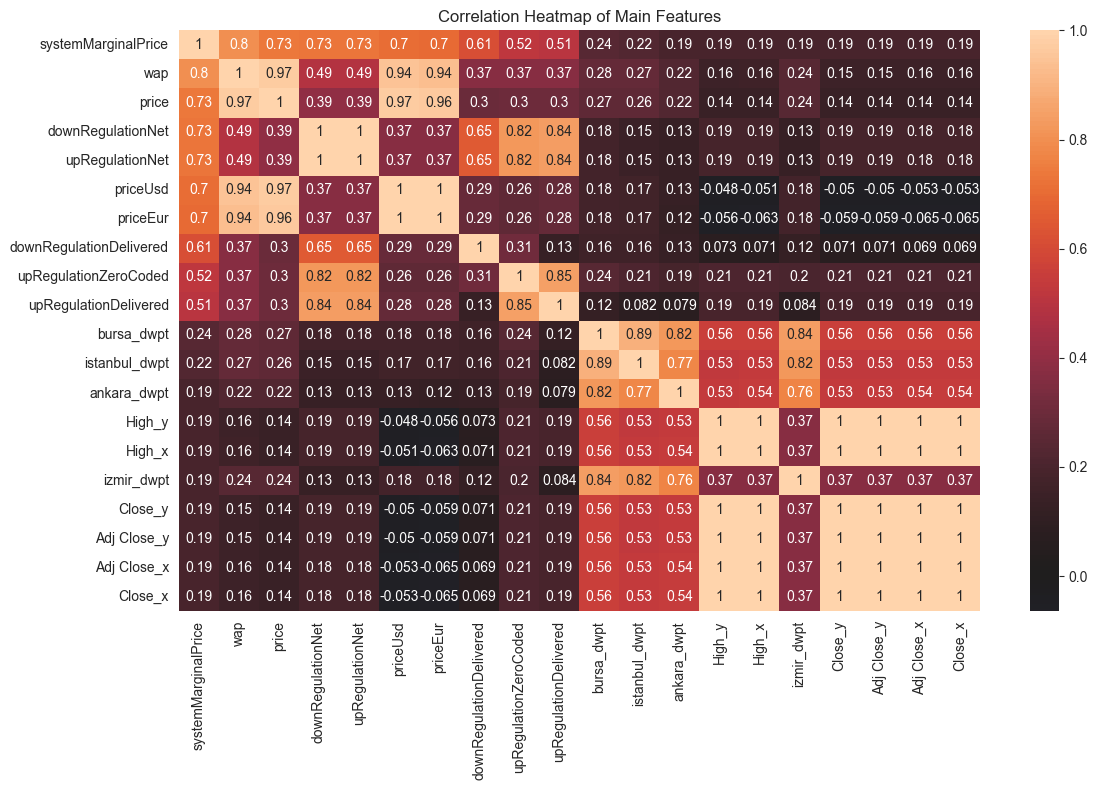

In [24]:
# Create correlation heatmap for main features
top_corr = correlations[abs(correlations) > 0.1][:20]
main_features = top_corr.index
plt.figure(figsize=(12, 8))
sns.heatmap(df[main_features].corr(), annot=True, center=0)
plt.title('Correlation Heatmap of Main Features')
plt.tight_layout()
plt.show()